In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import h5py as  h
import torch
import torch.nn as nn
import skimage.transform as skt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict({"num_trajs":807,
        "sl":96,
        "batch_size":20,
        "chan_size":3,
        "num_particles":30,
        "window_length":6,
        "h":64,
        "img_size":(132,96),
        "emb_obs":32,
        "emb_act":32,
        "map_emb":32,
        "dropout":0.1, #we changed this from 0.5
        "obs_num":5,
        "resamp_alpha":0.5,
        "bp_length":10, 
        "clip":1.0,
        "lr":0.0005,
        "bpdecay":0.1,
        "l2_weight":1.0,
        "l1_weight":0.0})

In [4]:
shapes = []
def test(d, f, i):
    hh = h.File(dataloc + folder + "/" + i,'r')['feature']
    exfile = skt.resize(hh, (3, 132, hh.shape[2]))
    shapes.append(exfile.shape)
    return exfile
dataloc = "data/DCASE_2019_feature/"
folders = [i for i in os.listdir(dataloc) if not "." in i]
data = {}
for folder in folders:
    dataset = {i:test(dataloc, folder, i) for i in os.listdir(dataloc + folder)}
    data[folder] = dataset


In [5]:
keys = list(data['gcc_mic_dev'].keys())
e = {key:{k:data[k][key] for k in data if key in data[k]} for key in keys}

In [6]:
labels_order = []
labels = []
with open("data/DCASE_2019_feature/DCSSE_2019_labels.txt", 'r') as lbl:
    for line in lbl.readlines():
        line = line.split()
        labels.append((int(line[2]),int(line[3])))
        labels_order.append(line[0])
labels = np.array(labels)

In [7]:
feat_order = ['gcc_mic_dev', 'logmel_mic_dev', 'intensity_foa_dev', 'logmel_foa_dev']

# mic = microphone dataset

# foa = ambiosonic dataset

In [8]:
inputs = np.zeros((labels.shape[0], len(feat_order), args.chan_size, *args.img_size))
for lblidx, lbl in enumerate(labels_order):
    inputs[lblidx] = np.stack([e[lbl + ".h5"][k] for k in feat_order])

In [9]:
from custom_model import AudioDataset, AudioLocalizer
from custom_rnn import AudioRNN
from torch.utils.data import DataLoader

In [10]:
ds = AudioDataset(inputs, labels)
train_dataset, test_dataset = torch.utils.data.random_split(ds, [(train_size := len(ds)*4//5), len(ds) - train_size],generator=torch.Generator().manual_seed(42))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=20,
                            num_workers=8, pin_memory=True, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=20,
                            num_workers=8, pin_memory=True, shuffle=True, drop_last = True)
model = AudioLocalizer(args)
# rnnmodel = AudioRNN(args)
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr)
# rnnoptimizer = torch.optim.RMSprop(rnnmodel.parameters(), lr=args.lr)

In [12]:
f = enumerate(train_loader)

In [14]:
model.train()
losses = []
c = 0
for epoch in tqdm(range(1)):
    el = []
    for iteration, data in f:
        c += 1
        gcc, mic, intensity, foa, lbl = data

        model.zero_grad()
        loss, log_loss, particle_pred = model.step(
            gcc, mic, intensity, foa, lbl, args)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        loss_last = log_loss.to('cpu').detach().numpy()
        loss_all = loss.to('cpu').detach().numpy()
        el.append((loss_all, loss_last))
    losses.append(el)

100%|██████████| 1/1 [01:15<00:00, 75.47s/it]


In [15]:
new_losses = [[(float(j[0]),float(j[1])) for j in i] for i in losses]

In [16]:
import json
with open("test.json", 'w') as f:
    json.dump(new_losses, f)

In [17]:
np_losses = np.array(new_losses)

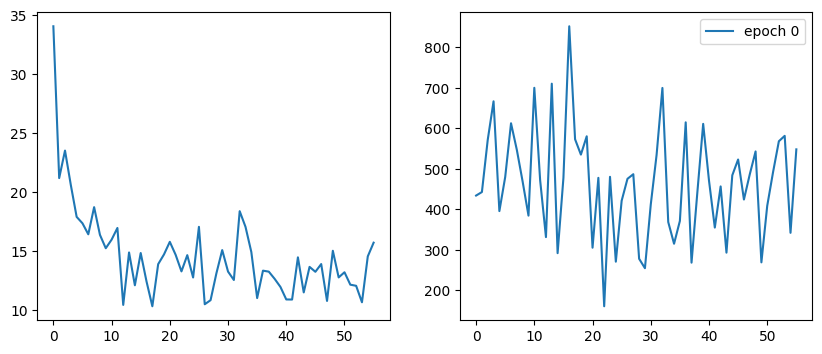

In [18]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize = (10,4))
for nidx, npl in enumerate(np_losses[::10]):
    l = npl[:,0]
    ll = npl[:,1]
    ax0.plot(l, label = f"epoch {nidx*10}")
    ax1.plot(ll, label = f"epoch {nidx*10}")
plt.legend()
plt.show()